In [2]:
##  MAP SEUL  ##


import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib.colors import LogNorm
import os

os.environ['PROJ_LIB'] = r'C:\Users\gauth_000\Documents\miniconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'
from mpl_toolkits.basemap import Basemap


#Carte à faire

nom_fichier='21_11_2020.nc'


fh=Dataset(nom_fichier, mode = 'r' )

    
long = fh.groups['PRODUCT'].variables['longitude'][:][0,:,:]
lat = fh.groups['PRODUCT'].variables['latitude'][:][0,:,:]
    

#shape pour faire les for
shape_long=fh.groups['PRODUCT'].variables['longitude'].shape
    
#donnée
no=fh.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column_precision'][0,:,:]
qa=fh.groups['PRODUCT'].variables['qa_value'][:][0,:,:]

shape=fh.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column_precision'].shape

#nombre de pixel pris en compte (qa valide)
pix=np.zeros([shape[1],shape[2]]) 


#on fait la moyenne
"""for i in range (0,shape[1]):
    #pourcentage pour voir l'avancement
    print(float (i/shape[1]))
    for j in range (0,shape[2]):
        if no[i][j]!=0: #pixel nul?
            pix[i][j]=1
"""


  
m = Basemap(width=1000000,height=1000000,resolution='l',projection='stere',lat_0=45.1667,lon_0=5.717)   
xi, yi = m(long, lat)


# Plot Data
cs = m.pcolor(xi,yi,np.squeeze(no),vmin=1e-5, vmax=9e-4,norm=LogNorm(), cmap='jet')


#add grid    
m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=5)
m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=5)


#Add coastlines, states and country
m.drawcoastlines()
m.drawcountries()


# Add Colorbar
no2_units = fh.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column_precision'].units
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label(no2_units)

# Add Title
plt.title('NO2 in atmosphere')
plt.savefig('No1', dpi = 600)
plt.show()




ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [4]:
##  TRAITEMENT 2  ##


#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#Importation des bibliotheque
import numpy as np
from netCDF4 import Dataset
import pickle


nom_sauv="sauvegarde2019conf"
nom_sauv_pix="sauvegardePix2019conf"


#variable pour la discretisation spatial
pas_long=0.2
debut_long=0
fin_long=10
N_long= int ((fin_long-debut_long)/pas_long)+1

pas_lat=0.2
debut_lat=40
fin_lat=50
N_lat=int ((fin_lat-debut_lat)/pas_lat)+1

#discretisation
longitude=np.linspace(debut_long,fin_long,N_long)   #0=>10 pas 0.02
latitude=np.linspace(debut_lat,fin_lat,N_lat)  #40=>50 pas 0.02
   


#Carte à faire
nom_fichier=[]
nom_fichier.append('21_11_2020.nc')

fh=[]
for i in range (0,len(nom_fichier)):
    fh.append(Dataset (nom_fichier[i], mode = 'r' ))
    
no=[]#nouvelles maps discretisées

#partie pour la discretisation
for i in range(0,len(fh)):
    #vrai longitude et latitude
    long = fh[i].groups['PRODUCT'].variables['longitude'][:][0,:,:]
    lat = fh[i].groups['PRODUCT'].variables['latitude'][:][0,:,:]
    
    #shape pour faire les for
    shape_long=fh[i].groups['PRODUCT'].variables['longitude'].shape
    
    #donnée
    no_nd=fh[i].groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column_precision'][0,:,:]
    qa_nd=fh[i].groups['PRODUCT'].variables['qa_value'][:][0,:,:]
    
    #donnée avec discretisation
    pixel=np.zeros([N_lat,N_long])
    nb_pix=np.zeros([N_lat,N_long])
    
    
    indice_lat=0
    indice_long=0
    
    #pourcentage de réalisation
    print(float(i/len(fh)))
    
    #on parcours tous les pixels
    for i in range(0,shape_long[1]):
        for j in range(0,shape_long[2]):
            
            #on verifie si on est dans l'intervalle de long et lat
            if((long[i,j]>=debut_long and long[i,j]<=fin_long) and (lat[i,j]>=debut_lat and lat[i,j]<=fin_lat)):
                #nouveau indice pour discretisation
                indice_long=int ((long[i,j]-debut_long)/pas_long)
                indice_lat=int ((lat[i,j]-debut_lat)/pas_lat)
                
            #valeur qui permet d'évaluer si un pixel n'est pas faussé
            if(qa_nd[i,j]>=0.7):
                pixel[indice_lat,indice_long]=no_nd[i,j]
                nb_pix[indice_lat,indice_long]+=1
  
    #si plusieurs pixels sont pris en compte, on fait une moyenne
    for i in range(0,N_lat):
        for j in range(0,N_long):
            if(nb_pix[i,j]!=0):
                pixel[i,j]=pixel[i,j]/nb_pix[i,j]  
                
    #nouvelles maps discretisées
    no.append(pixel)


#Partie du traitement pour faire la moyenne

#nombre de pixel pris en compte (qa valide)
nb_pix=np.zeros([N_lat,N_long]) 

#moyenne des pixels
res_no = np.zeros([N_lat,N_long]) 

#on fait la moyenne
for i in range (0,N_lat):
    #pourcentage pour voir l'avancement
    """print(float (i/N_lat))"""
    for j in range (0,N_long):
        for k in range (0,len(fh)):
            if no[k][i][j]!=0: #pixel nul?
                res_no[i][j]+=no[k][i][j]
                nb_pix[i][j]+=1
        if(nb_pix[i][j]!=0):
            res_no[i][j]=res_no[i][j]/nb_pix[i][j]
        else:
            res_no[i][j]=0



#enregistrement de données
fichierSauvegarde = open(nom_sauv,"wb")
pickle.dump(res_no, fichierSauvegarde)
fichierSauvegarde.close()

fichierSauvegarde = open(nom_sauv_pix,"wb")
pickle.dump(nb_pix, fichierSauvegarde)
fichierSauvegarde.close()



0.0


<ipython-input-5-f849759f6c5b>:56: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs = m.pcolor(xi,yi,np.squeeze(res_no),vmin=6e-7, vmax=3e-5,norm=LogNorm(), cmap='jet')
<ipython-input-5-f849759f6c5b>:56: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cs = m.pcolor(xi,yi,np.squeeze(res_no),vmin=6e-7, vmax=3e-5,norm=LogNorm(), cmap='jet')


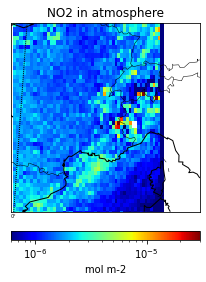

<ipython-input-5-f849759f6c5b>:84: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs1 = m1.pcolor(xi,yi,np.squeeze(nb_pix), cmap='jet')


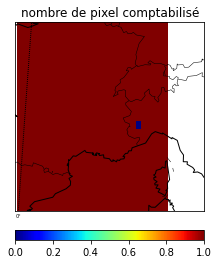

In [5]:
##  CARTE 2  ##


#!/usr/bin/env python3
# -*- coding: utf-8 -*-


#Importation des bibliotheque
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib.colors import LogNorm
import os
import pickle

#Debug de la bibliotheque pour windows
os.environ['PROJ_LIB'] = r'C:\Users\gauth_000\Documents\miniconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'
from mpl_toolkits.basemap import Basemap

nom_sauv="sauvegarde2019conf"
nom_sauv_pix="sauvegardePix2019conf"

#variable pour faire le plot
pas_long=0.2
debut_long=0
fin_long=10
N_long= int ((fin_long-debut_long)/pas_long)+1

pas_lat=0.2
debut_lat=40
fin_lat=50
N_lat=int ((fin_lat-debut_lat)/pas_lat)+1


longitude=np.linspace(debut_long,fin_long,N_long)   #0=>10 pas 0.01
latitude=np.linspace(debut_lat,fin_lat,N_lat)  #40=>50 pas 0.01
   

#recupere des données
fichierSauvegarde = open(nom_sauv,"rb")
res_no = pickle.load(fichierSauvegarde)
fichierSauvegarde.close()
fichierSauvegarde1 = open(nom_sauv_pix,"rb")
nb_pix = pickle.load(fichierSauvegarde1)
fichierSauvegarde1.close()


#Unité
fh=Dataset('21_11_2020.nc', mode = 'r' )
no2_units = fh.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column_precision'].units


#MAP pour le NO2 
m = Basemap(width=1000000,height=1000000,resolution='l',projection='stere',lat_ts=40,lat_0=45.1667,lon_0=5.717)   
xi, yi = m(longitude, latitude)


# Plot Data
cs = m.pcolor(xi,yi,np.squeeze(res_no),vmin=6e-7, vmax=3e-5,norm=LogNorm(), cmap='jet')


#add grid    
m.drawparallels(np.arange(-80., 81., 20.), labels=[1,0,0,0], fontsize=5)
m.drawmeridians(np.arange(-180., 181., 20.), labels=[0,0,0,1], fontsize=5)


#Add coastlines, states and country
m.drawcoastlines()
m.drawcountries()


# Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label(no2_units)

# Add Title
plt.title('NO2 in atmosphere')
plt.savefig('NO2 in atmosphere', dpi = 600)
plt.show()


#MAP 2 pour les qa
m1 = Basemap(width=1000000,height=1000000,resolution='l',projection='stere',lat_ts=40,lat_0=45.1667,lon_0=5.717)


#plot data  
cs1 = m1.pcolor(xi,yi,np.squeeze(nb_pix), cmap='jet')


#add grid    
m1.drawparallels(np.arange(-80., 81., 20.), labels=[1,0,0,0], fontsize=5)
m1.drawmeridians(np.arange(-180., 181., 20.), labels=[0,0,0,1], fontsize=5)


#Add coastlines, states and country
m1.drawcoastlines()
m1.drawcountries()


#Add color bar
cbar1 = m1.colorbar(cs1, location='bottom', pad="10%") 


# Add Title
plt.title('nombre de pixel comptabilisé')
plt.savefig('nombre de pixel qa.png', dpi = 600)
plt.show()


